# Using PyLops and OccamyPy together

@Author: Francesco Picetti - picettifrancesco@gmail.com

In this notebook, we will combine [PyLops](https://pylops.readthedocs.io/en/stable/) and OccamyPy.

First, let me express my gratitude to Matteo Ravasi;
PyLops has strongly inspired us to publish OccamyPy, as our contribution to the scientific community.

In the following, we leverage PyLops rich library of operators to be used with OccamyPy, which we found to be agile for distributed computation and nonlinear problems.

In [1]:
import numpy as np
import occamypy as o
import matplotlib.pyplot as plt
import pylops

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Mechanism of the interface

Let's say we have a VectorNumpy

In [2]:
x = o.VectorNumpy((3,5)).set(1.)

and we want to use a PyLops operator like

In [3]:
Dp = pylops.Diagonal(np.arange(x.size))

we can cast such operator to OccamyPy with `FromPylops`

In [4]:
D = o.pylops_interface.FromPylops(domain=x, range=x, op=Dp)

Now we have a OccamyPy operator that can be used in our inversion

In [5]:
D.dotTest(True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 3.24249267578125e-05 seconds
Applying adjoint operator add=False
 Runs in: 1.5735626220703125e-05 seconds
Dot products add=False: domain=1.117678e+01 range=1.117678e+01 
Absolute error: 0.000000e+00
Relative error: 0.000000e+00 

Applying forward operator add=True
 Runs in: 1.049041748046875e-05 seconds
Applying adjoint operator add=True
 Runs in: 9.298324584960938e-06 seconds
Dot products add=True: domain=2.235356e+01 range=2.235356e+01 
Absolute error: 0.000000e+00
Relative error: 0.000000e+00 

-------------------------------------------------


At the same time, we can cast a Numpy-based OccamyPy operator to PyLops with `ToPylops`

In [6]:
S = o.Scaling(x, 2.)

In [7]:
Sp = o.pylops_interface.ToPylops(S)

Such operator can be used inside PyLops

In [8]:
pylops.utils.dottest(Sp, x.size, x.size, tol=1e-6, complexflag=0, verb=True)

print("\t", np.isclose((Sp * x.arr.ravel()).reshape(x.shape), 2. * x.arr).all())

Dot test passed, v^T(Opu)=-2.696536 - u^T(Op^Tv)=-2.696536
	 True


## Example 1: CT Scan Imaging

Let's replicate [this example](https://pylops.readthedocs.io/en/latest/tutorials/ctscan.html#sphx-glr-tutorials-ctscan-py). The modeling equation is $\mathbf{d} = \mathbf{R} \, \mathbf{m}$


In [9]:
def radoncurve(x, r, theta):
    curve = (r - ny // 2) / (np.sin(np.deg2rad(theta)) + 1e-15) \
            + np.tan(np.deg2rad(90 - theta)) * x + ny // 2
    return curve

Load the image and create the 2D Radon transform operator as done in PyLops

In [10]:
x = np.load('data/shepp_logan_phantom.npy').T
x = x / x.max()
nx, ny = x.shape
    
ntheta = 150
theta = np.linspace(0., 180., ntheta, endpoint=False)

RLop = pylops.signalprocessing.Radon2D(np.arange(ny), np.arange(nx),
                                       theta, kind=radoncurve,
                                       centeredh=True, interp=False,
                                       engine='numpy', dtype='float64')

Let's see the operator at work

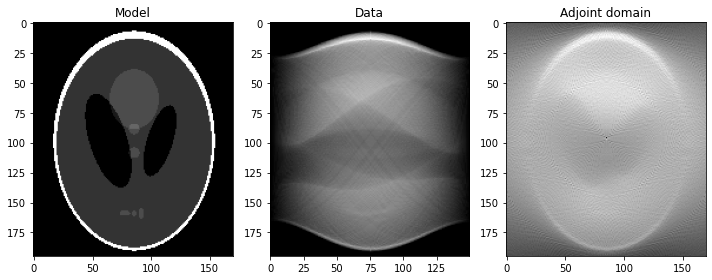

In [11]:
y = RLop.H * x.ravel()
y = y.reshape(ntheta, ny)

xrec = RLop * y.ravel()
xrec = xrec.reshape(nx, ny)

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(x.T, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(y.T, cmap='gray')
axs[1].set_title('Data')
axs[1].axis('tight')
axs[2].imshow(xrec.T, cmap='gray')
axs[2].set_title('Adjoint domain')
axs[2].axis('tight')
fig.tight_layout()
plt.show()

Now let's build the OccamyPy equivalent

In [12]:
x_ = o.VectorNumpy(x)
y_ = o.VectorNumpy((ntheta, ny))
R_ = o.pylops_interface.FromPylops(x_, y_, RLop.H)
y_ = R_ * x_
xrec_ = R_.H * y_

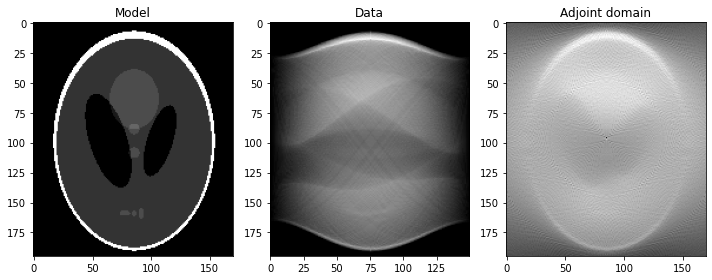

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(x_.plot().T, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(y_.plot().T, cmap='gray')
axs[1].set_title('Data')
axs[1].axis('tight')
axs[2].imshow(xrec_.plot().T, cmap='gray')
axs[2].set_title('Adjoint domain')
axs[2].axis('tight')
fig.tight_layout()
plt.show()

Set up the TV-regularized inversion as done in PyLops

In [14]:
mu = 1.5
lamda = 1.
niter = 3
niterinner = 4

problemTV = o.GeneralizedLasso(x_.clone().zero(), y_, R_, eps=lamda / mu,
                               reg=o.Gradient(x_, stencil="backward"))

SB = o.SplitBregman(o.BasicStopper(niter=niter),
                    niter_inner=niterinner,
                    niter_solver=20,
                    linear_solver="LSQR",
                    warm_start=True)

SB.setDefaults(save_obj=True)

In [15]:
SB.run(problemTV, verbose=True, inner_verbose=False)

##########################################################################################
            SPLIT-BREGMAN Solver
    Restart folder: /tmp/restart_2022-04-22T01-48-19.749447/
    Inner iterations: 4
    Solver iterations: 20
    L1 Regularizer weight: 6.67e-01
    Bregman update weight: 1.00e+00
    Using warm start option for inner problem
##########################################################################################

iter = 0, obj = 5.43461e+06, df_obj = 5.43e+06, reg_obj = 0.00e+00, rnorm = 3.30e+03
iter = 1, obj = 1.58628e+03, df_obj = 2.20e+01, reg_obj = 1.56e+03, rnorm = 2.20e+01
iter = 2, obj = 1.41801e+03, df_obj = 1.39e+01, reg_obj = 1.40e+03, rnorm = 2.14e+01
iter = 3, obj = 1.26275e+03, df_obj = 1.44e+01, reg_obj = 1.25e+03, rnorm = 2.14e+01
Terminate: maximum number of iterations reached

##########################################################################################
            SPLIT-BREGMAN Solver end
######################################

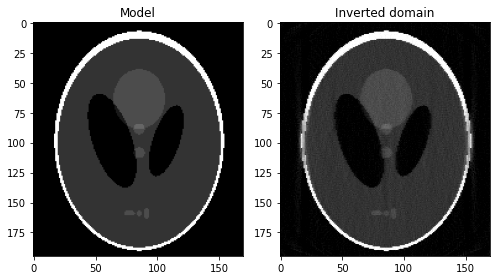

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(x_.plot().T, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(problemTV.model.plot().T, vmin=0, vmax=1, cmap='gray')
axs[1].set_title('Inverted domain')
axs[1].axis('tight')
fig.tight_layout()
plt.show()